In [83]:
import numpy as np
from math import sin, cos, log, e
import matplotlib.pyplot as plt
from scipy.stats import norm as normal_dist
from time import time
import pyaudio

plt.rcParams['figure.figsize'] = [30, 10]
names = ["A BbB C DbD EbE F GbG Ab"[(i%12)*2:(i%12)*2+2].strip() + str(i//12) for i in range(120)]

In [94]:
CHUNK = 8192
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 15
WAVE_OUTPUT_FILENAME = "output.wav"

In [95]:
# Generate FFT_S and FFT_C
s = time()

NOTES = ["A", "Bb", "B", "C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab"]

slen = CHUNK

num_notes = 96
num_segments = 1

logs = (np.arange(num_notes * num_segments) - (num_segments//2)) * (1/(12 * num_segments))
freqs = 27.5 * 2**logs * 2

nfft_s = np.zeros((len(freqs), slen))
nfft_c = np.zeros((len(freqs), slen))

for i in range(len(freqs)):
    seconds = CHUNK/RATE
    num_cycles = seconds * freqs[i] # i.e 55 hz * (2048/44100) = 2.55 cycles
    n = num_cycles * 2 * np.pi
    nfft_s[i] = np.arange(slen) * (n/slen)
    nfft_c[i] = np.arange(slen) * (n/slen)
#     for j in range(slen):
#         nfft_s[i][j] = (n*j/slen)
#         nfft_c[i][j] = (n*j/slen)

nfft_s = np.sin(nfft_s)
nfft_c = np.cos(nfft_c)
m = time()

# Generate COND
condense = np.zeros((120, 12))
for i in range(120):
    condense[i][i%12] = 1 
    

# Generate HMAT

sigma = 1/36
notes = [(i/12) for i in range(120)]
mat = np.zeros((len(logs), len(notes)))
# each value in mat is the probability that a fft frequency belongs to a note or it's harmonic series
for i in range(len(logs)):
#         print(i, end="\r")
    for j in range(len(notes)):
        v = abs(logs[i] - notes[j])
        mat[i][j] = (v/sigma)
mat = 2 * (1- normal_dist().cdf(mat))

# Generate H_INV
inv_harm = np.zeros((120,120))
for i in range(120):
    for j in [0, 12, 19, 24, 28, 31]: #harmonic series is +12, +7, +5, +4, +3
        if i + j < 120:
            inv_harm[i][i+j] = 1

e = time()

print(e - s, "seconds taken to generate all matrices", (e-s)/(1/44100))
print(m - s, "seconds to generate FFT", (m-s)/(1/44100))

0.07420754432678223 seconds taken to generate all matrices 3272.552704811096
0.05532550811767578 seconds to generate FFT 2439.854907989502


highest granularity needed: 7.6756894297203e-06


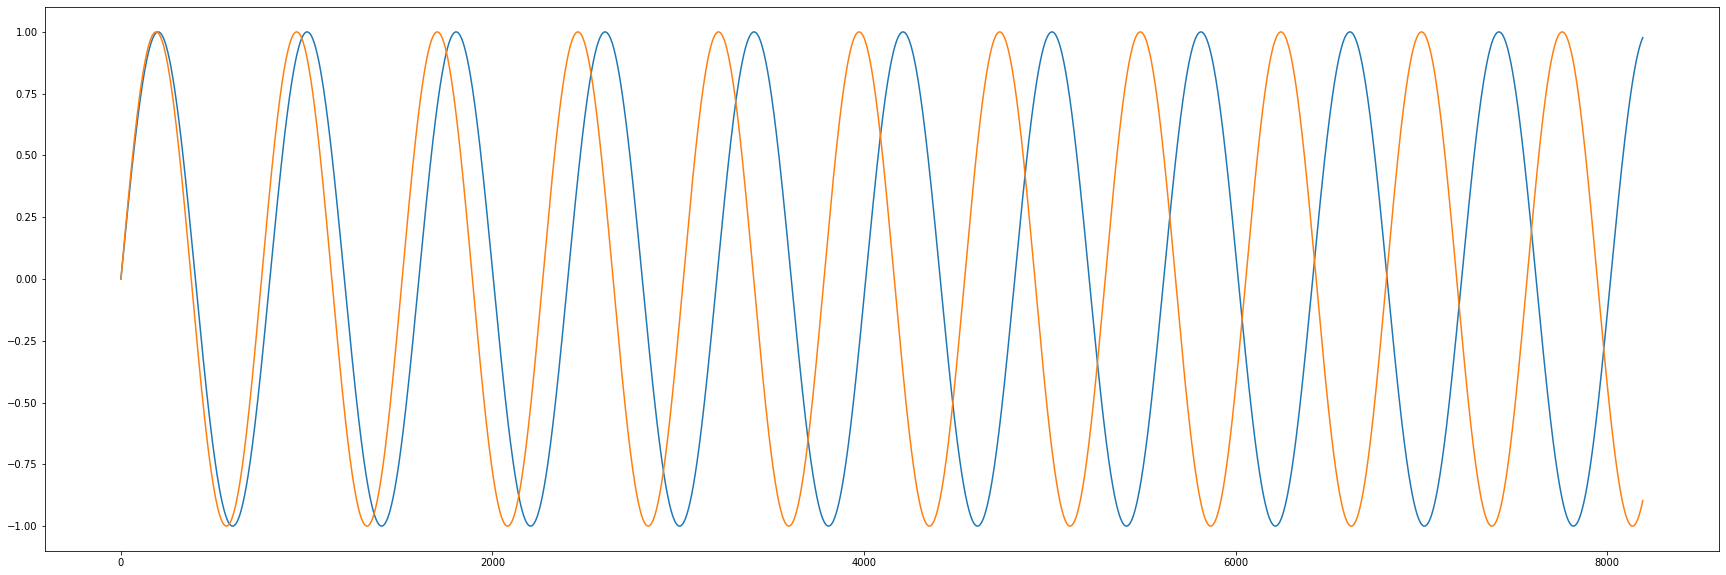

In [98]:
for i in range(num_notes//12): 
    for j in range(12):
        assert np.linalg.norm(nfft_s[j][0::(2**i)] - nfft_s[12*i + j][:(slen >> (i))]) < 1e-8

# smallest delta in any of the functions
print("highest granularity needed:" , (1 - cos(1/2048 * (2048/44100 * 27.5 * 2 * np.pi))))

plt.plot(nfft_s[0])
plt.plot(nfft_s[1])

# plt.plot(nfft_s[12])
# plt.plot(nfft_s[24])

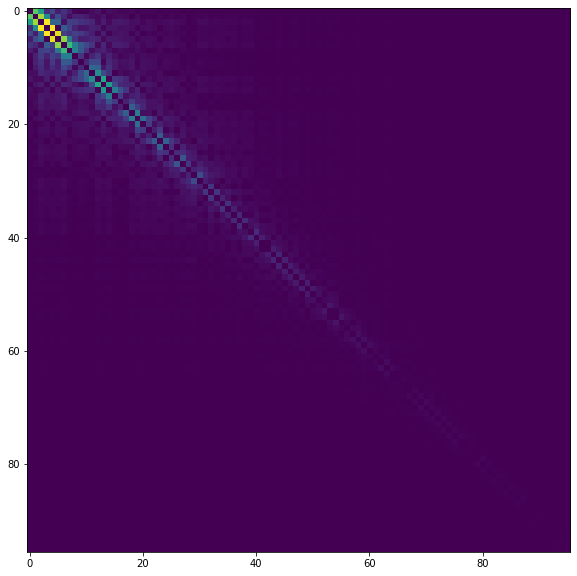

0.12894863848799387


In [100]:
sims = np.matmul(nfft_c, nfft_c.T)
sims -= np.diag(np.diag(sims))
# sims = np.abs(sims)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.abs(sims))
plt.show()

print(np.amax(sims)/(max(np.diag(np.matmul(nfft_c, nfft_c.T)))))

In [7]:
def find_note_2(sample, FFTS, FFTC, COND, verbose=False):
    dft2s = np.matmul(FFTS, sample) # (120, 2048) x (2048, 1) -> (120,1)
    dft2c = np.matmul(FFTC, sample) # (120, 2048) x (2048, 1) -> (120,1)
    psd2 = ((dft2s**2) + (dft2c**2)) # (120, 1) + (120, 1) -> (120, 1)
    c = np.matmul(psd2, COND) # (12,120) x (120, 1) -> (12, 1)
    c /= np.linalg.norm(c)
#     c /= max(c)
    
    
    return list(zip(NOTES,c))
#     psd = psd2 * psd2

In [8]:
def find_note(sample, FFTS, FFTC, HMAT, H_INV, COND, verbose=False):
    dft2s = np.matmul(FFTS, sample)
    dft2c = np.matmul(FFTC, sample)
    psd2 = ((dft2s**2) + (dft2c**2))**0.5
    psd_n = np.matmul(psd2, HMAT)

    nl = np.matmul(H_INV, psd_n) # (120,120) (120,1) = (120,1)
    nr = np.matmul(H_INV.T, psd_n) # (120,120) (120,1) = (120,1)
    
    #(120,1) (1,120) = (120,120)
    
    #nl = diag(Hn (H.Tn).T)= diag(Hnn.TH)
    nlr = nl * nr
    
    c = np.matmul(nlr, COND)
    c /= np.linalg.norm(c)
    
    
    if verbose:
        
        # NEW STUFF
    
        print(nl.shape, nr.shape)

        nl2 = np.reshape(nl, (120,1))
        nr2 = np.reshape(nr, (1,120))

        m = np.matmul(nl2, nr2)
        print(m.shape)

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.imshow(m)
        plt.show()

        print("Outer product of psd")
        psdn2 = np.reshape(psd_n, (120,1))
        m2 = np.matmul(psdn2, psdn2.T)
        print(m2.shape)

        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.imshow(m2)
        plt.show()

        # NEW STUFF END
    
        
        print("PSD of modified FFT")
        plt.bar(range(len(psd2)), psd2)
        plt.show()
        
        print("PSD of modified FFT converted to notes")
        plt.bar(range(len(psd_n)), psd_n)
        plt.show()
        
        print("Left harmonic series")
        plt.bar(range(len(nl)), nl)
        plt.show()
        
        print("Right harmonic series")
        plt.bar(range(len(nr)), nr)
        plt.show()
        
        print("harmonic series multiplied")
        plt.bar(range(len(nlr)), nlr)
        plt.show()
        
        print("psd")
        plt.bar(range(len(nlr)), psd2**2)
        plt.show()
        
        print("final answer")
        plt.bar(NOTES, c)
        plt.show()
        print(list(zip(NOTES,c)))
        
        print("final answer 2")
        c2 = np.matmul((psd2**2), COND)
        c2 /= np.linalg.norm(c2)
        plt.bar(NOTES, c2)
        plt.show()
        print(list(zip(NOTES,c2)))
   
    return list(zip(NOTES,c))

In [9]:
def find_note_3(sample, FFTS, FFTC, verbose=False):
    dft2s = np.matmul(FFTS, sample)
    dft2c = np.matmul(FFTC, sample)
    ret = np.zeros(12)
    for i in range(len(FFTS)):
        s = dft2s[i]
        c = dft2c[i]
        ret[i%12] += s*s + c*c
    ret /= np.linalg.norm(ret)
    
    psd2 = ((dft2s**2) + (dft2c**2))
    plt.bar(range(len(psd2)), psd2)
    plt.show()
    
    return list(zip(NOTES,np.round(ret, 6)))

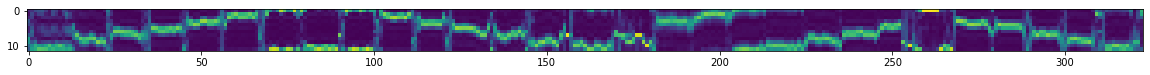

In [12]:
m = np.genfromtxt("c_imp/tune.csv", delimiter=",")
m.shape
fig, ax = plt.subplots(figsize=(20,40))
im = ax.imshow(m.T[::-1])
plt.show()

In [13]:
m/(s-m)
m/s

for mm in m:
    s = max(mm)/(sum(mm))
    print(NOTES[np.argmax(mm)],"\t", log(s),"\t",  s, max(mm)/(sum(mm) - max(mm)), s/(1-s))

C 	 -1.6933789503558019 	 0.18389709385421632 0.22533566841798017 0.2253356684179802
A 	 -1.6993398916163296 	 0.1828041547888201 0.2236968724939856 0.22369687249398557
Bb 	 -1.343790043437219 	 0.2608551403807075 0.3529147730460641 0.3529147730460641
A 	 -1.1788866021075595 	 0.30762105263157896 0.44429579177815615 0.44429579177815626
A 	 -1.290644725526422 	 0.2750933661879645 0.3794879966008075 0.3794879966008074
A 	 -1.251430031427954 	 0.2860953788065337 0.4007473411899971 0.4007473411899971
Bb 	 -1.1733226390561655 	 0.3093374152635032 0.4478850050658562 0.44788500506585627
A 	 -1.3859149264729553 	 0.2500948766603416 0.33350202429149806 0.333502024291498
Bb 	 -1.3953250915842919 	 0.24775248102743722 0.3293496818252366 0.3293496818252366
Bb 	 -1.0987968160478834 	 0.33327182988145204 0.4998616299986162 0.4998616299986162
A 	 -1.405492433041889 	 0.24524625935162092 0.32493546721734634 0.32493546721734634
A 	 -1.6431633698340122 	 0.19336738122438013 0.23972174782355152 0.2397217

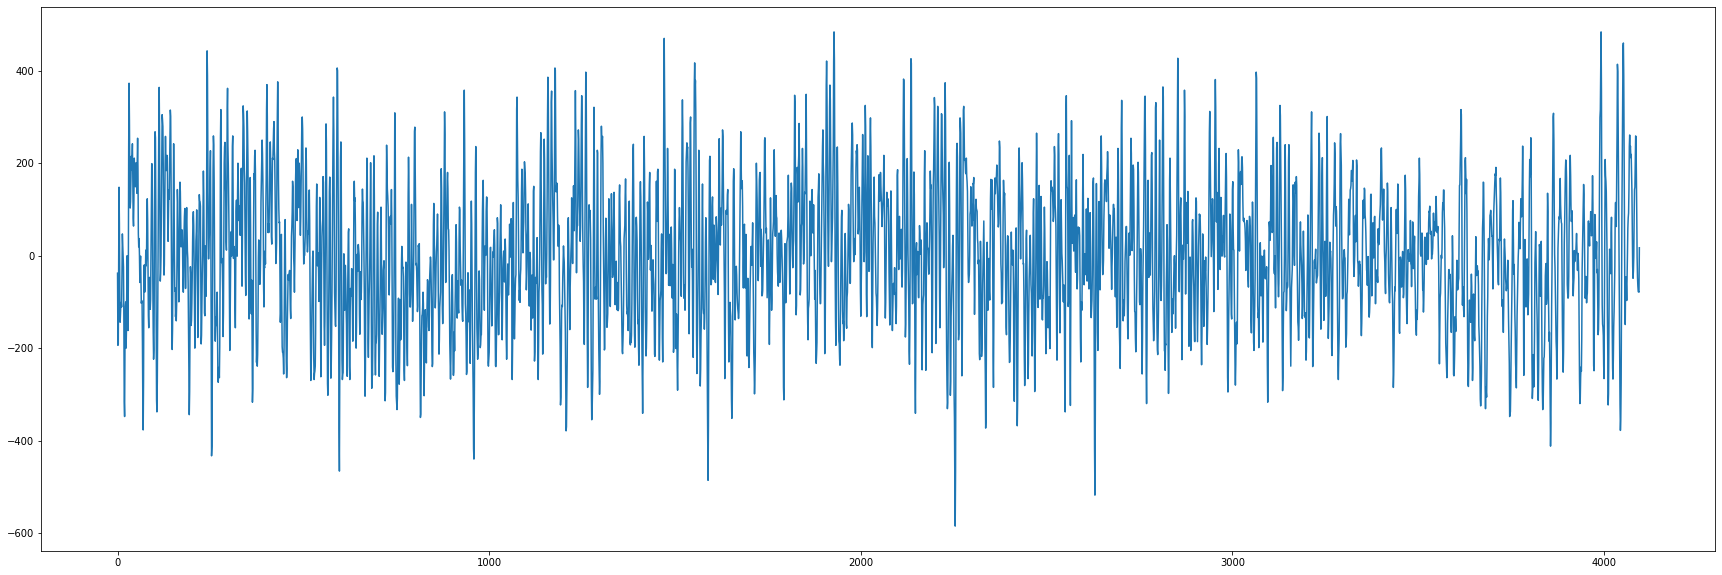

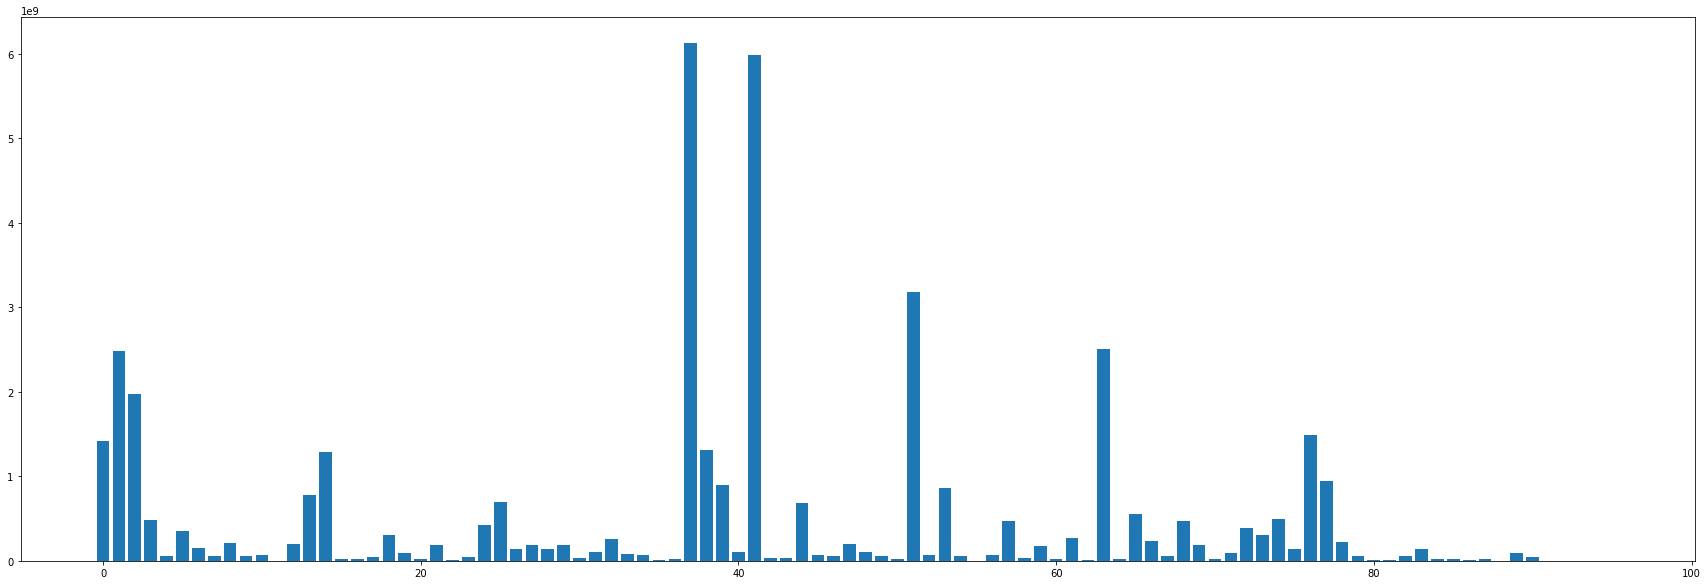

0.149729 0.624562 0.304988 0.431840 0.110777 0.524975 0.063005 0.023338 0.100207 0.061592 0.017624 0.038343 
ratio of max to rest:  0.34196005514619326


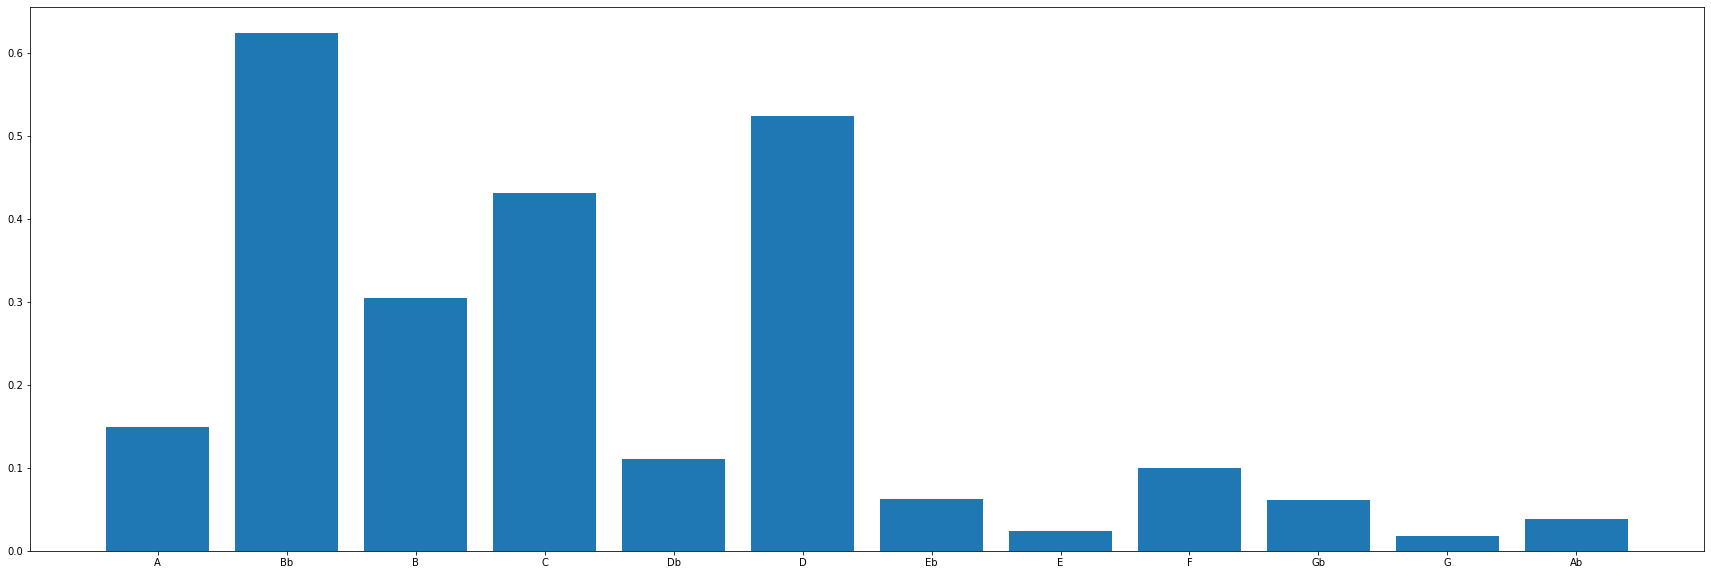

In [237]:
#signal
f = open("c_imp/samples.csv")
r = f.read().strip().split("\n")
f.close()

sample = np.asarray([int(n) for n in r]).astype(np.float64)
assert len(sample) == slen 

# sample2 = (nfft_s[18] + nfft_s[6] +  nfft_s[24]) * 2**11
# plt.plot(sample2)

plt.plot(sample)
plt.show()

n = find_note_3(sample, nfft_s, nfft_c)
vals = np.array([v[1] for v in n])
for i in range(12):
    print("%0.6f" % vals[i], end = " ")
print("\nratio of max to rest: ", max(vals)/(sum(vals) - max(vals)))
plt.bar([v[0] for v in n], vals)
plt.show()

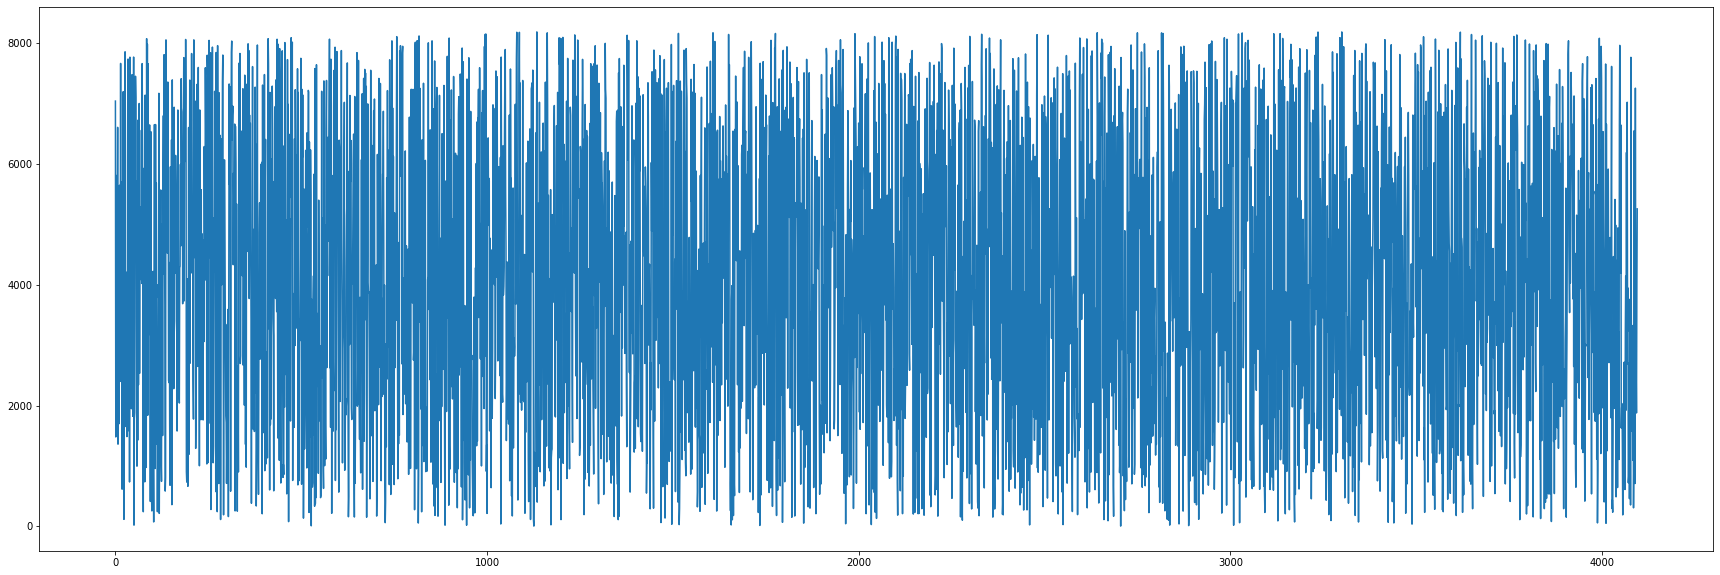

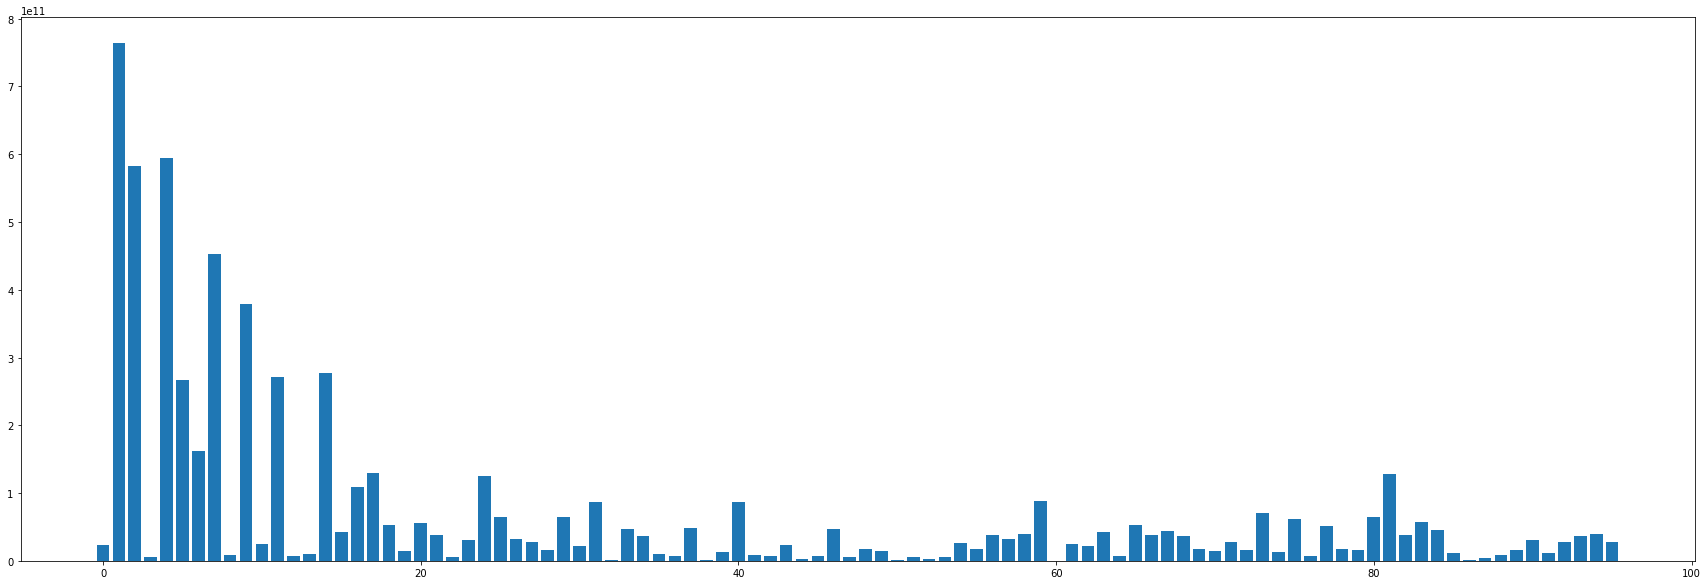

[0.229868 0.95607  0.88172  0.192436 0.787944 0.564006 0.336492 0.632764
 0.221114 0.648254 0.23432  0.491958]


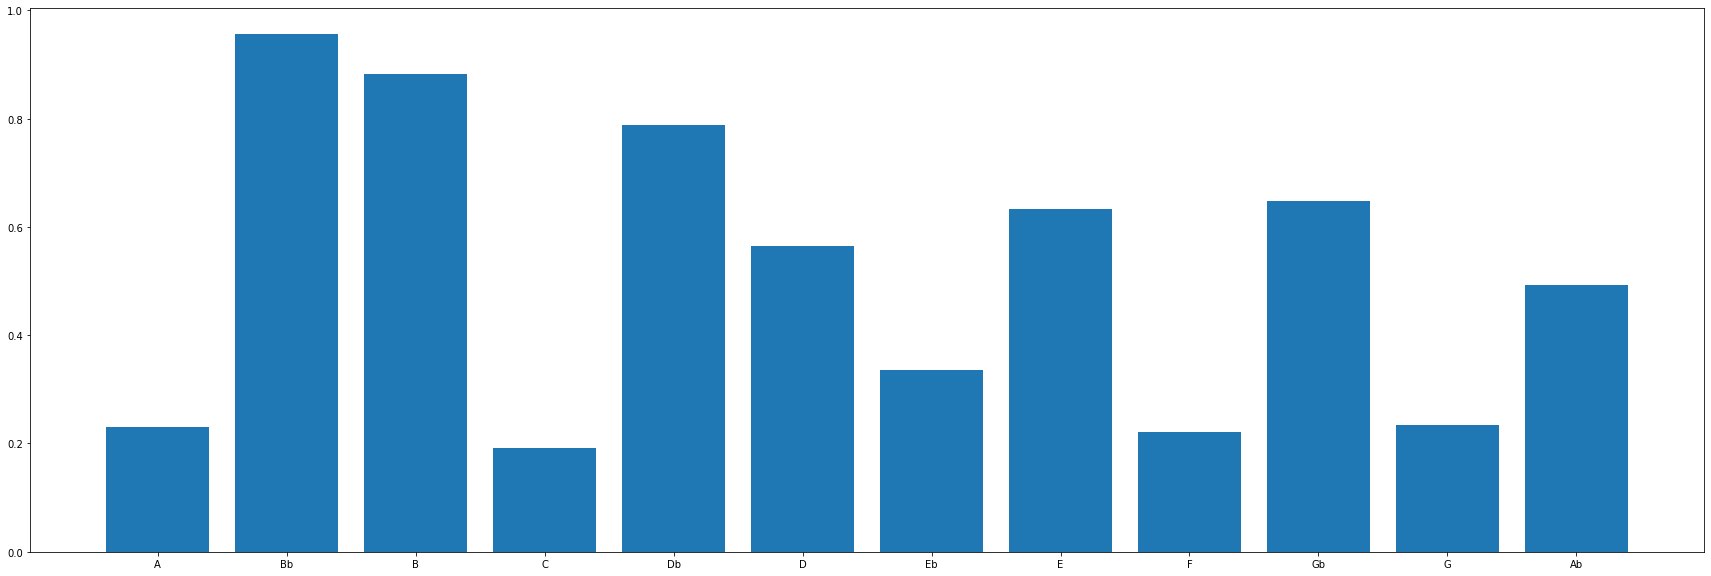

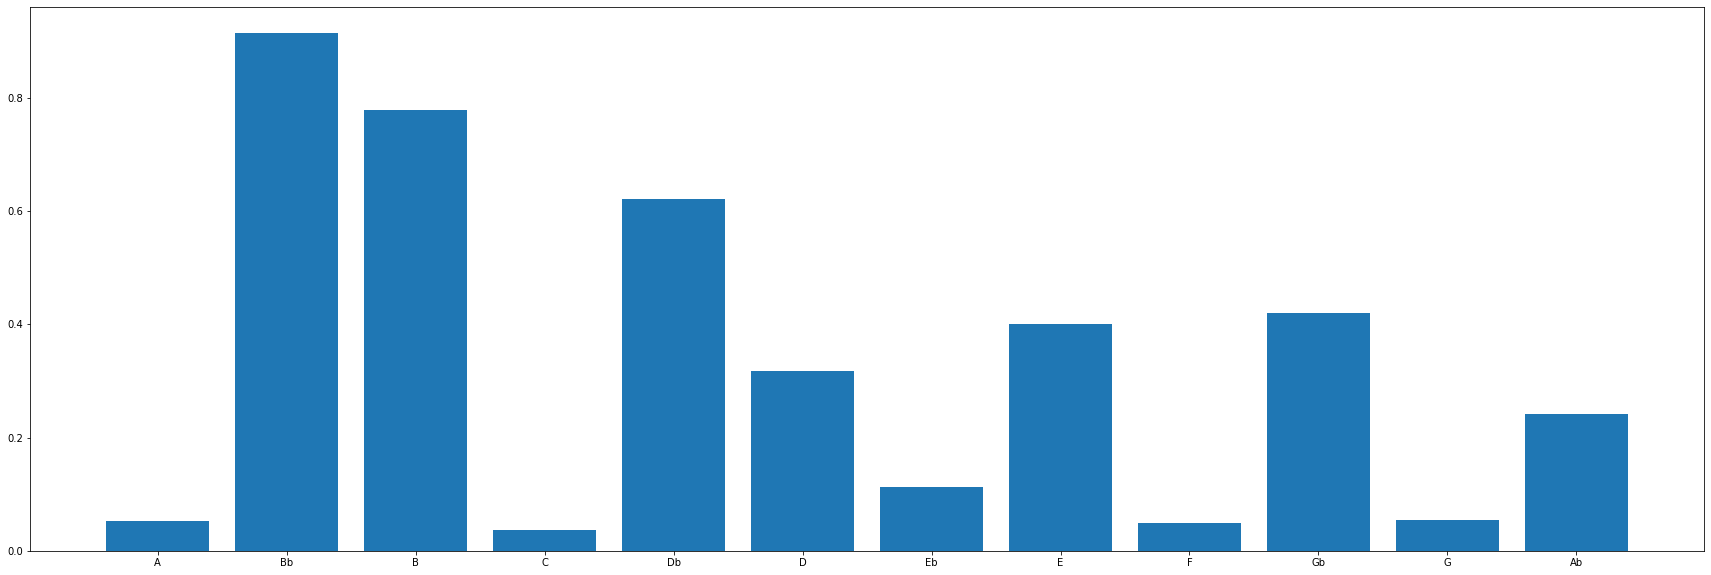

In [185]:
#noise

sample = np.random.rand(slen) * 2**13
plt.plot(sample)
plt.show()

n = find_note_3(sample, nfft_s, nfft_c)
vals = np.array([v[1] for v in n])
vals *= 2
print(vals)
plt.bar([v[0] for v in n], vals)
plt.show()

plt.bar([v[0] for v in n], (vals**2))
plt.show()

(120,) (120,)
(120, 120)


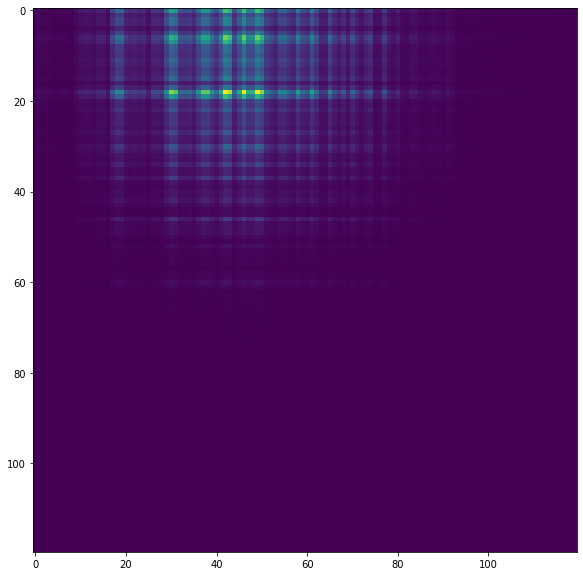

Outer product of psd
(120, 120)


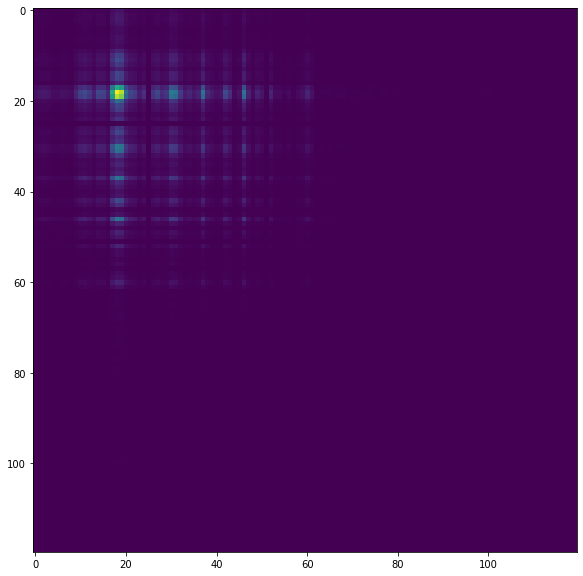

PSD of modified FFT


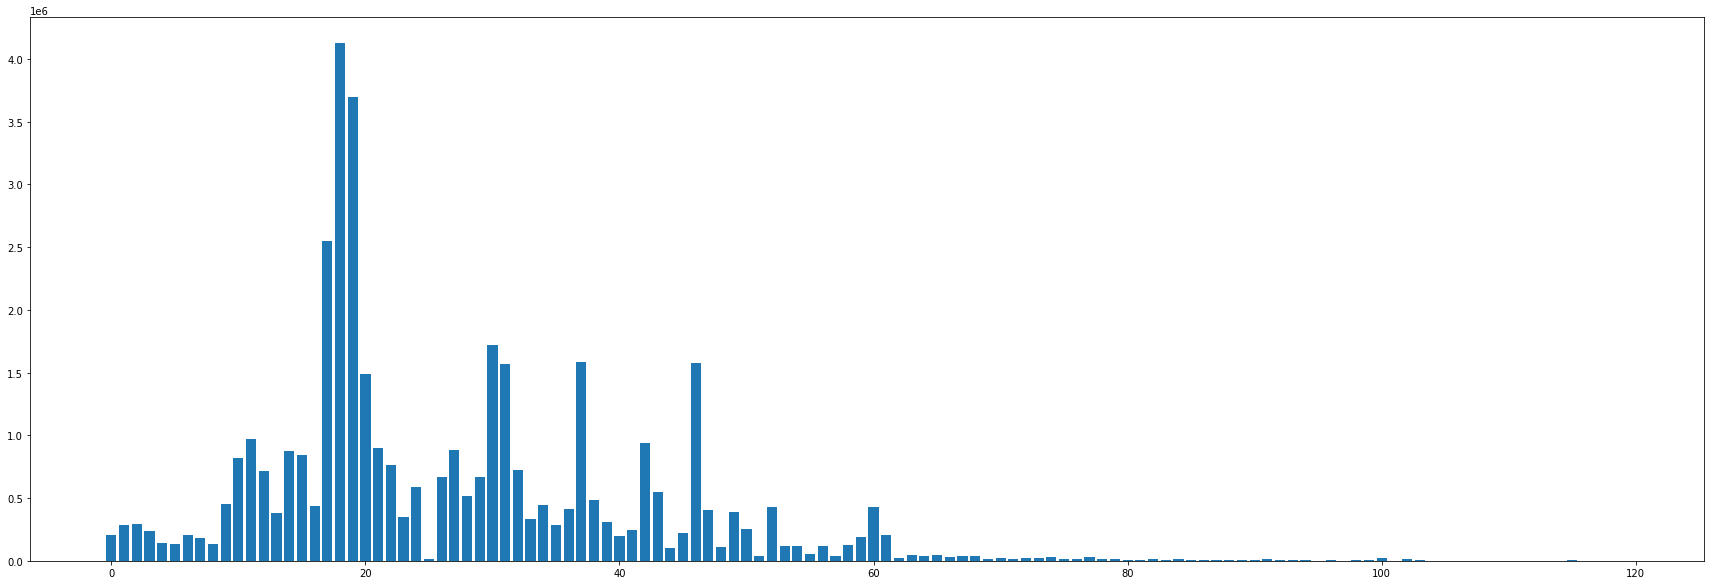

PSD of modified FFT converted to notes


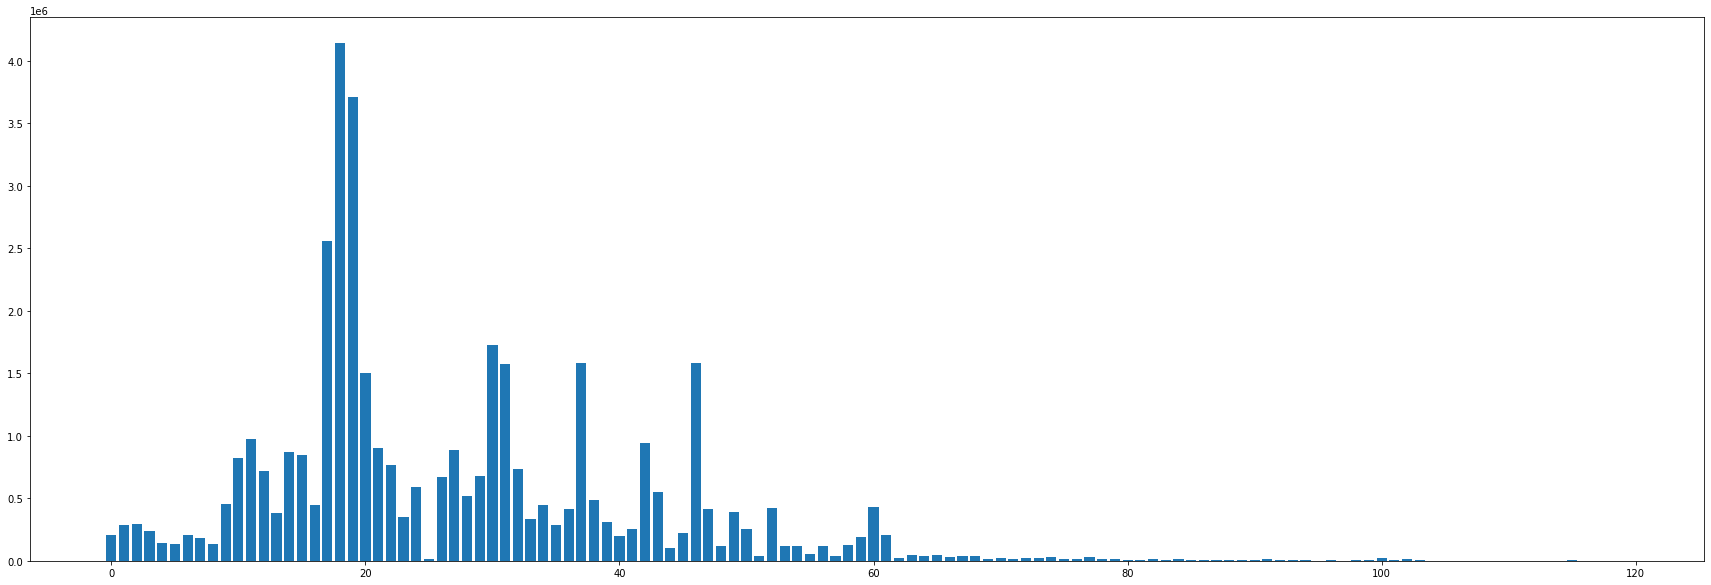

Left harmonic series


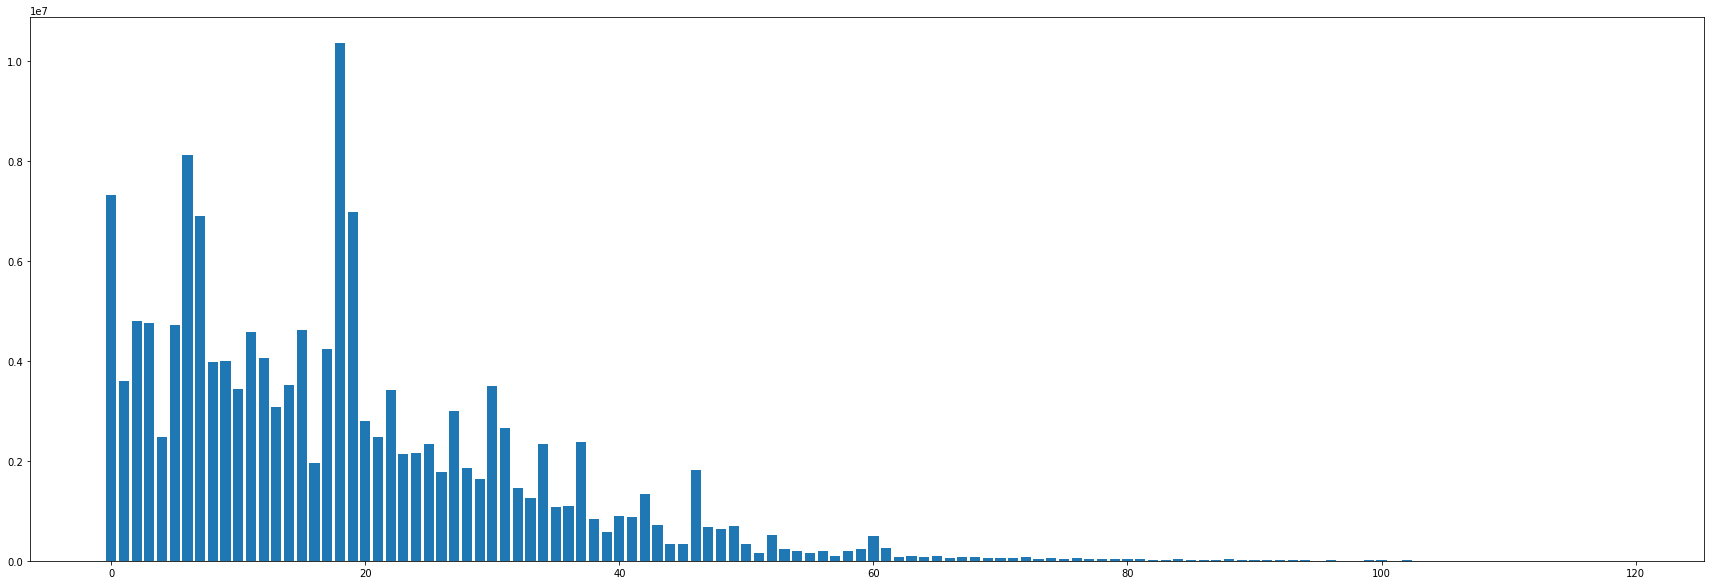

Right harmonic series


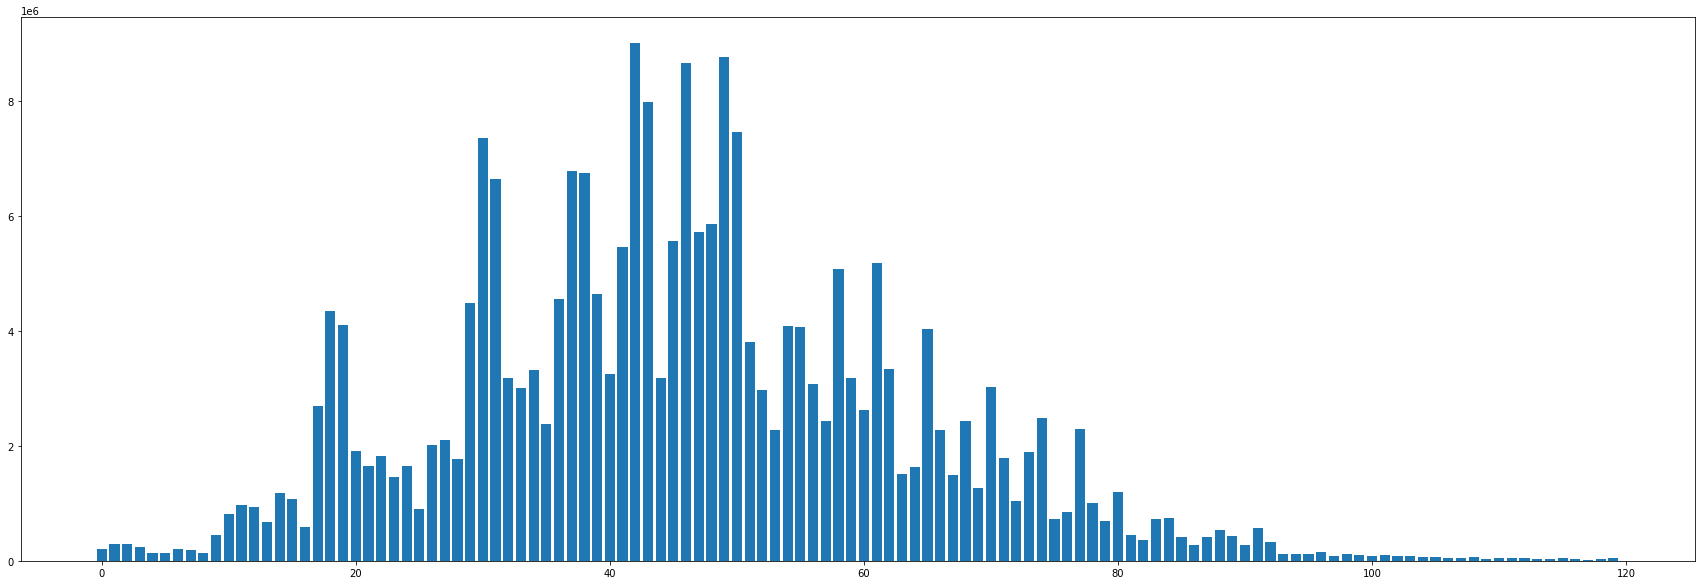

harmonic series multiplied


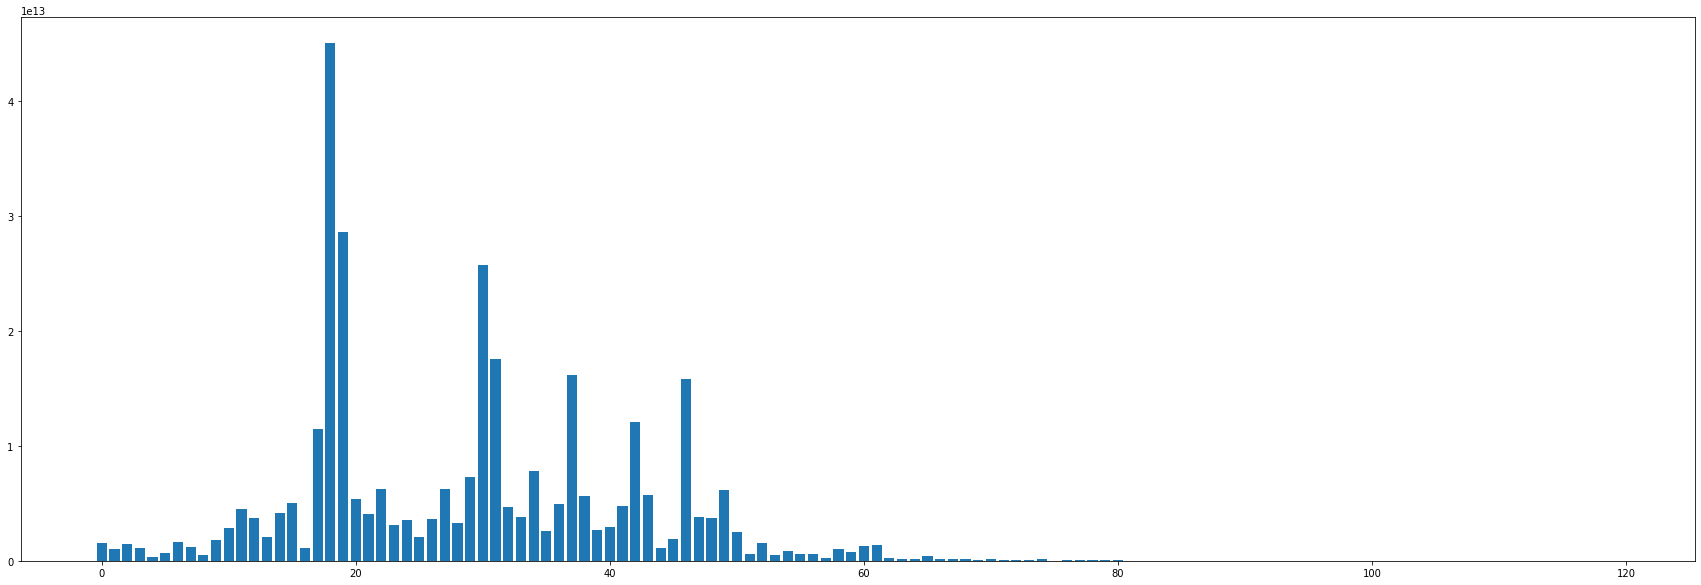

psd


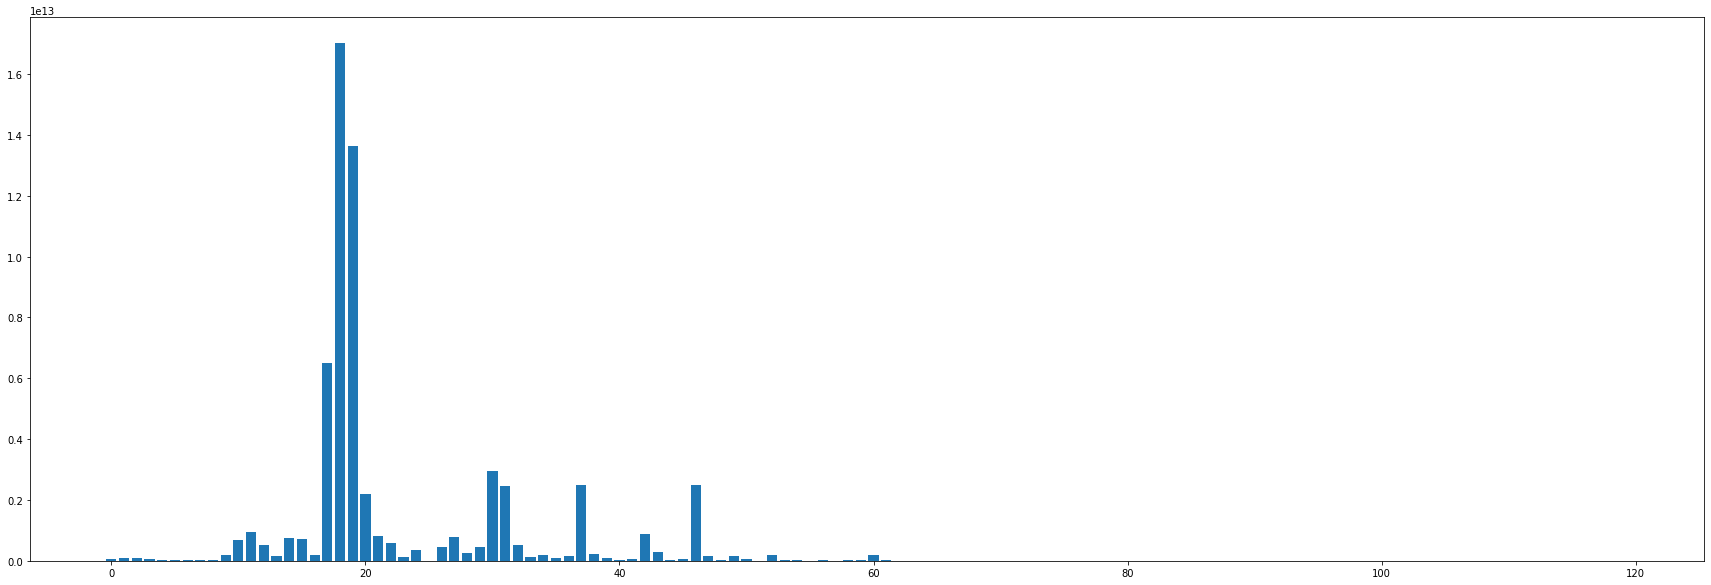

final answer


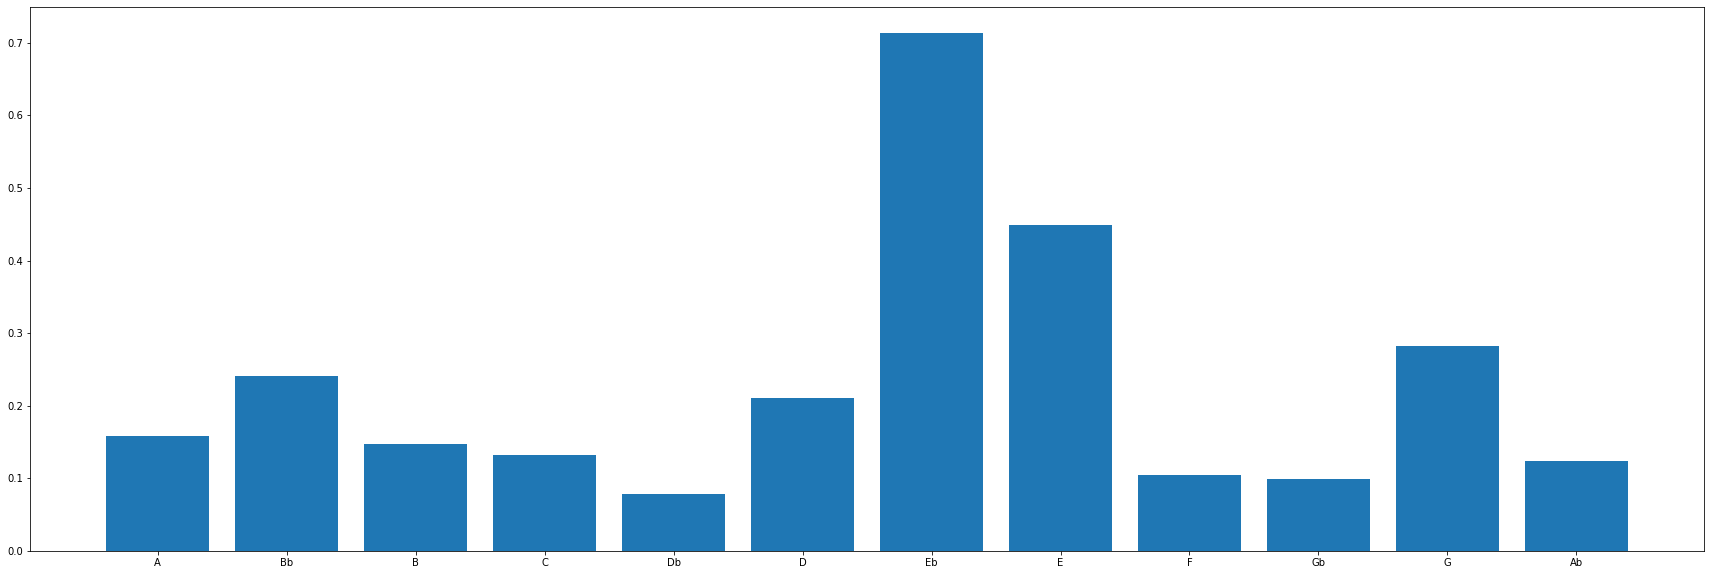

[('A', 0.15843416292448634), ('Bb', 0.24150038265135632), ('B', 0.14740647211589478), ('C', 0.13239811996284032), ('Db', 0.07880174490595553), ('D', 0.21023979866432851), ('Eb', 0.7135032940997104), ('E', 0.4494842859651908), ('F', 0.10409933239747979), ('Gb', 0.0993490262651959), ('G', 0.2821733623223213), ('Ab', 0.12432209221684429)]
final answer 2


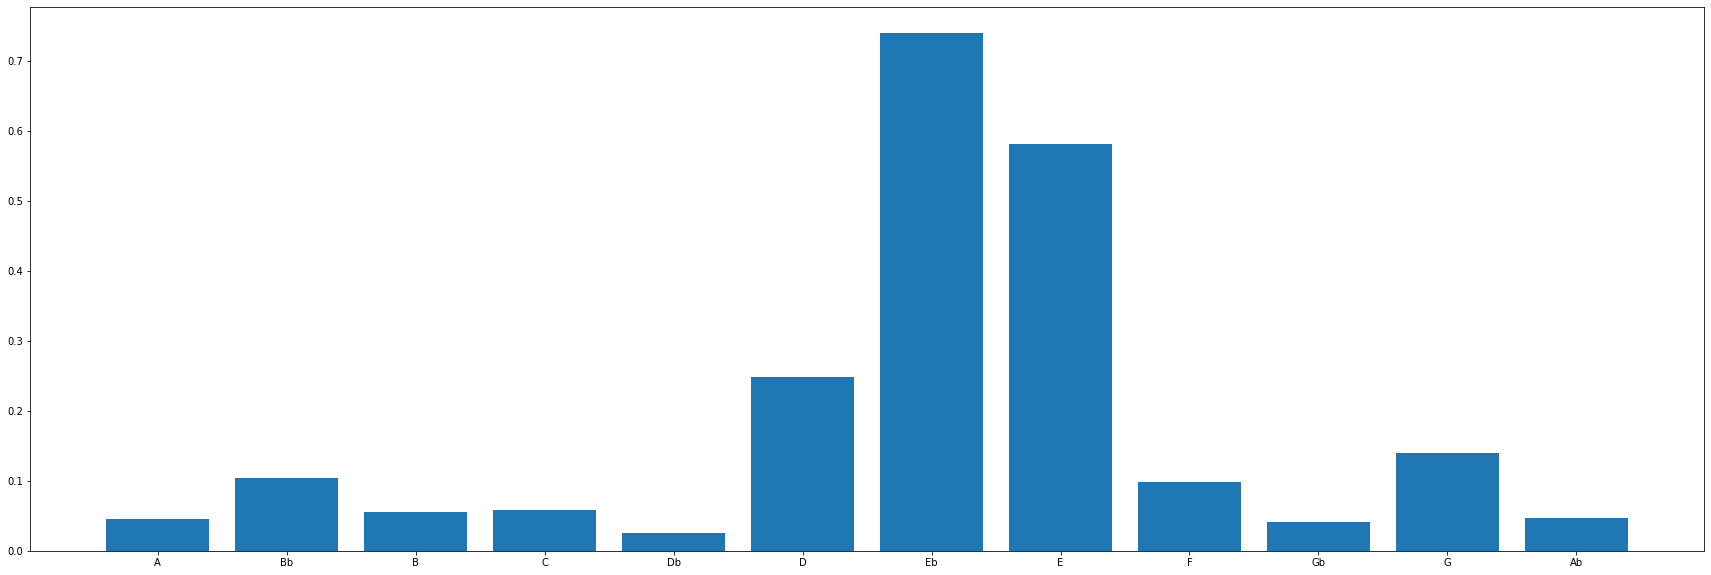

[('A', 0.044935037328386544), ('Bb', 0.10339224591795833), ('B', 0.05611501266341284), ('C', 0.057914256224273375), ('Db', 0.02473366360040541), ('D', 0.24874929048056402), ('Eb', 0.739682696366895), ('E', 0.5813801617475683), ('F', 0.098319713675346), ('Gb', 0.04133640260661593), ('G', 0.1397512568512019), ('Ab', 0.04754686853044413)]
[('A', 0.15843416292448634), ('Bb', 0.24150038265135632), ('B', 0.14740647211589478), ('C', 0.13239811996284032), ('Db', 0.07880174490595553), ('D', 0.21023979866432851), ('Eb', 0.7135032940997104), ('E', 0.4494842859651908), ('F', 0.10409933239747979), ('Gb', 0.0993490262651959), ('G', 0.2821733623223213), ('Ab', 0.12432209221684429)]


In [38]:
n = find_note(sample, nfft_s, nfft_c, mat, inv_harm, condense, verbose=True)
print(n)
# plt.bar([v[0] for v in n], [v[1] for v in n])
# plt.show()

In [37]:
p = pyaudio.PyAudio()

# input("Press any key to start recording")

print("* recording")

frames = []

maxes = []

last = ""

stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    sample = np.frombuffer(data, dtype=np.int16)
    
    n = find_note(sample, nfft_s, nfft_c, mat, inv_harm, condense)
    
    n_names, n_vals = [v[0] for v in n], [v[1] for v in n]

    high_idx = np.argmax(n_vals)
    if n_vals[high_idx] > 0.5:
        note = n_names[high_idx]
        if note != last:
            last = note
            print(note)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

* recording
A
Ab
A
Bb
D
Db
C
Db
E
F
E
Eb
E
Eb
E
F
E
Gb
Bb
A
Bb
B
Bb
G
D
Db
G
B
A
Ab
E
Gb
F
E
* done recording


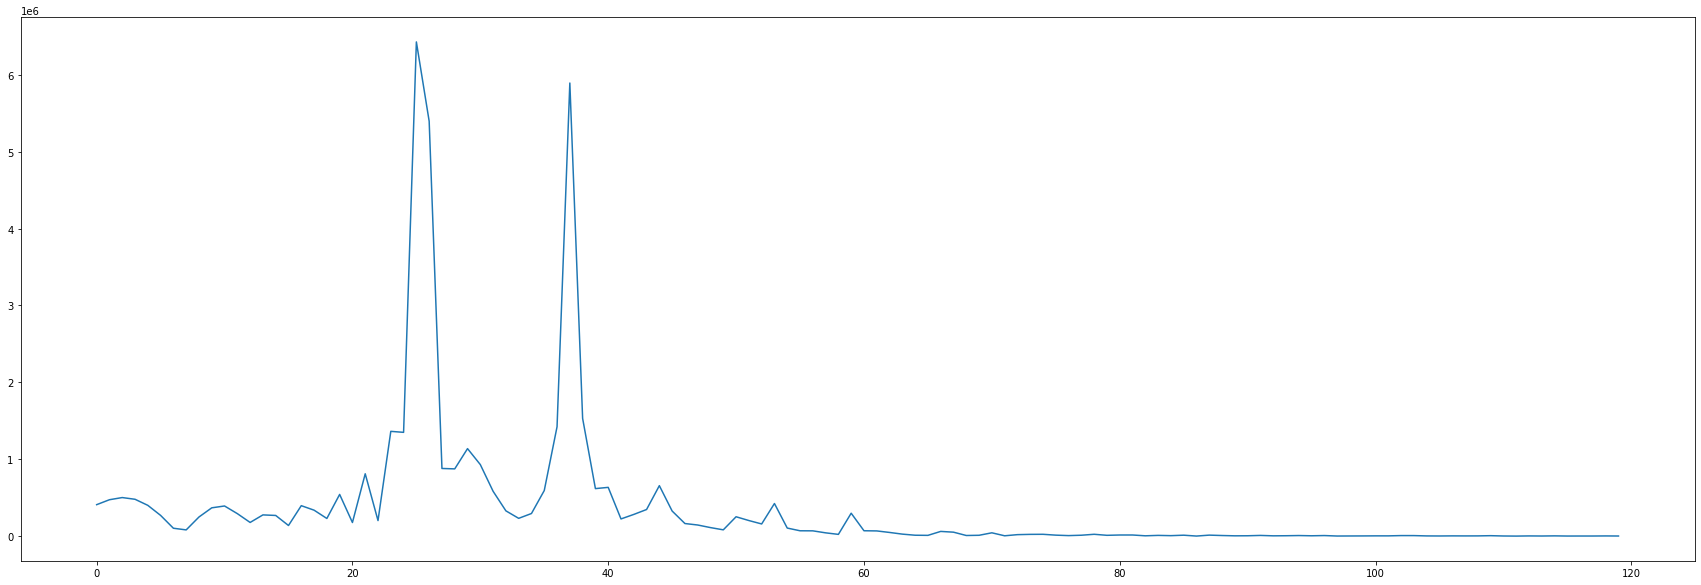

In [187]:
dft2s = np.matmul(nfft_s, sample)
dft2c = np.matmul(nfft_c, sample)

psd2 = ((dft2s**2) + (dft2c**2))**0.5
plt.plot(psd2)

In [ ]:
# Traditional FFT
""" 
fft_sin = np.zeros((slen//2, slen))
fft_cos = np.zeros((slen//2, slen))

for i in range(slen//2):
    for j in range(slen):
        fft_sin[i][j] = (i*j*np.pi*2/(2048))
        fft_cos[i][j] = (i*j*np.pi*2/(2048)) 

fft_sin = np.sin(fft_sin)
fft_cos = np.sin(fft_cos)

dfts = np.matmul(fft_sin, sample)
dftc = np.matmul(fft_cos, sample)
psd = ((dfts**2) + (dftc**2))**0.5
plt.plot(psd)
plt.show()
"""
pass

In [188]:
avgs_long = []
avgs_short = []
avgs_noc = []
for i in range(10000):
    sample2 = np.random.rand(slen)
    s = time()
    n = find_note(sample2, nfft_s, nfft_c, mat, inv_harm, condense)
    e = time()
    avgs_long.append(e-s)
    
    s = time()
    n = find_note_2(sample2, nfft_s, nfft_c, condense)
    e = time()
    avgs_short.append(e-s)
    
    s = time()
    n = find_note_3(sample2, nfft_s, nfft_c)
    e = time()
    avgs_noc.append(e-s)
    
print(np.average(avgs_long) / (1/44100), np.average(avgs_long)) #takes about 10 samples to figure out, or about 0.00023 seconds
print(np.average(avgs_short) / (1/44100), np.average(avgs_short)) #takes about 8 samples to figure out, or about 0.00015 seconds
print(np.average(avgs_noc) / (1/44100), np.average(avgs_noc)) #takes about 8 samples to figure out, or about 0.00015 seconds


61.839383933544156 0.0014022536039352417
29.966606426239014 0.0006795148849487305
62.38325292348862 0.0014145862340927125


In [346]:
tot_len = 850
diagram = """
     |
      \-----\
     /------/
     \-------\
    /--------/
    \---------\
   /----------/
   \-----------\
  /------------/
  \-------------\
 /--------------/
 \---------------\
/----------------/
|
"""
circ_len = 12 * 2 * 0.25 * np.pi * 10 # 12 strings * 2 quarter turns per string * 0.25 of a full circle * (pi * 10 mm diameter)
circ_len

rem_len = tot_len - circ_len

str_len = sum([2**(i/12) for i in range(12)])

str_len, rem_len, circ_len

base_len = rem_len//str_len

new_sum = circ_len + sum([base_len * 2**(i/12) for i in range(12)])
new_sum

assert new_sum < tot_len

print([round(base_len * 2**(i/12), 3) for i in range(12)])

[39.0, 41.319, 43.776, 46.379, 49.137, 52.059, 55.154, 58.434, 61.909, 65.59, 69.49, 73.622]


In [47]:
l0 =[
[0.116, 0.344, 0.898, 0.235, 0.065, 0.008, 0.006, 0.006, 0.017, 0.012, 0.027, 0.028],
[0.119, 0.138, 0.830, 0.178, 0.272, 0.104, 0.132, 0.263, 0.215, 0.051, 0.132, 0.089],
[0.179, 0.336, 0.480, 0.175, 0.322, 0.427, 0.231, 0.234, 0.283, 0.257, 0.158, 0.168],
[0.060, 0.635, 0.725, 0.130, 0.178, 0.048, 0.033, 0.044, 0.103, 0.019, 0.040, 0.034],
[0.055, 0.668, 0.720, 0.058, 0.030, 0.033, 0.020, 0.015, 0.024, 0.015, 0.026, 0.161],
[0.033, 0.573, 0.648, 0.039, 0.069, 0.100, 0.053, 0.058, 0.099, 0.147, 0.259, 0.360],
[0.051, 0.708, 0.603, 0.082, 0.059, 0.079, 0.029, 0.040, 0.100, 0.200, 0.029, 0.251],
[0.069, 0.675, 0.585, 0.128, 0.151, 0.193, 0.076, 0.102, 0.037, 0.084, 0.280, 0.135],
[0.118, 0.565, 0.708, 0.190, 0.137, 0.167, 0.151, 0.022, 0.119, 0.025, 0.038, 0.208],
[0.462, 0.593, 0.568, 0.160, 0.084, 0.108, 0.029, 0.017, 0.193, 0.099, 0.090, 0.110],
[0.011, 0.113, 0.667, 0.713, 0.176, 0.006, 0.037, 0.004, 0.022, 0.005, 0.027, 0.018],
[0.001, 0.035, 0.087, 0.970, 0.222, 0.039, 0.005, 0.005, 0.001, 0.005, 0.020, 0.011],
[0.004, 0.031, 0.098, 0.981, 0.156, 0.045, 0.011, 0.007, 0.003, 0.005, 0.025, 0.013],
[0.001, 0.040, 0.093, 0.974, 0.194, 0.048, 0.006, 0.005, 0.001, 0.008, 0.022, 0.014],
[0.004, 0.054, 0.021, 0.929, 0.362, 0.048, 0.003, 0.005, 0.007, 0.007, 0.010, 0.012],
[0.019, 0.050, 0.007, 0.790, 0.610, 0.025, 0.004, 0.003, 0.009, 0.003, 0.012, 0.006],
[0.004, 0.039, 0.060, 0.966, 0.244, 0.045, 0.005, 0.005, 0.003, 0.006, 0.012, 0.015],
[0.002, 0.034, 0.066, 0.962, 0.259, 0.046, 0.004, 0.004, 0.002, 0.007, 0.009, 0.013],
[0.008, 0.042, 0.030, 0.952, 0.297, 0.052, 0.007, 0.004, 0.005, 0.003, 0.018, 0.015],
[0.010, 0.046, 0.008, 0.865, 0.499, 0.034, 0.001, 0.004, 0.008, 0.004, 0.008, 0.010],
[0.006, 0.043, 0.010, 0.851, 0.522, 0.030, 0.001, 0.007, 0.008, 0.007, 0.009, 0.012],
[0.008, 0.040, 0.026, 0.944, 0.322, 0.046, 0.007, 0.004, 0.005, 0.003, 0.011, 0.009],
[0.006, 0.038, 0.042, 0.952, 0.299, 0.039, 0.006, 0.004, 0.004, 0.005, 0.015, 0.011],
[0.000, 0.042, 0.068, 0.964, 0.250, 0.047, 0.004, 0.005, 0.002, 0.008, 0.018, 0.013],
[0.005, 0.047, 0.059, 0.976, 0.196, 0.046, 0.011, 0.006, 0.004, 0.005, 0.020, 0.013],
[0.001, 0.062, 0.066, 0.972, 0.212, 0.044, 0.009, 0.007, 0.001, 0.010, 0.011, 0.019],
[0.003, 0.064, 0.036, 0.960, 0.265, 0.039, 0.007, 0.005, 0.002, 0.006, 0.011, 0.016],
[0.002, 0.061, 0.094, 0.979, 0.164, 0.047, 0.011, 0.006, 0.000, 0.010, 0.013, 0.017],
[0.007, 0.051, 0.028, 0.955, 0.286, 0.044, 0.007, 0.004, 0.004, 0.004, 0.010, 0.010],
[0.001, 0.046, 0.080, 0.972, 0.208, 0.042, 0.009, 0.005, 0.002, 0.009, 0.022, 0.016],
[0.003, 0.040, 0.101, 0.981, 0.154, 0.044, 0.010, 0.006, 0.002, 0.006, 0.024, 0.016],
[0.001, 0.038, 0.095, 0.971, 0.212, 0.039, 0.008, 0.006, 0.001, 0.008, 0.020, 0.023],
[0.005, 0.037, 0.059, 0.973, 0.211, 0.045, 0.010, 0.005, 0.004, 0.004, 0.019, 0.018],
]

l1 = [
[0.116, 0.344, 0.898, 0.235, 0.065, 0.008, 0.006, 0.006, 0.017, 0.012, 0.027, 0.028],
[0.119, 0.138, 0.830, 0.178, 0.272, 0.104, 0.132, 0.263, 0.215, 0.051, 0.132, 0.089],
[0.179, 0.336, 0.480, 0.175, 0.322, 0.427, 0.231, 0.234, 0.283, 0.257, 0.158, 0.168],
[0.060, 0.635, 0.725, 0.130, 0.178, 0.048, 0.033, 0.044, 0.103, 0.019, 0.040, 0.034],
[0.055, 0.668, 0.720, 0.058, 0.030, 0.033, 0.020, 0.015, 0.024, 0.015, 0.026, 0.161],
[0.033, 0.573, 0.648, 0.039, 0.069, 0.100, 0.053, 0.058, 0.099, 0.147, 0.259, 0.360],
[0.051, 0.708, 0.603, 0.082, 0.059, 0.079, 0.029, 0.040, 0.100, 0.200, 0.029, 0.251],
[0.069, 0.675, 0.585, 0.128, 0.151, 0.193, 0.076, 0.102, 0.037, 0.084, 0.280, 0.135],
[0.118, 0.565, 0.708, 0.190, 0.137, 0.167, 0.151, 0.022, 0.119, 0.025, 0.038, 0.208],
[0.462, 0.593, 0.568, 0.160, 0.084, 0.108, 0.029, 0.017, 0.193, 0.099, 0.090, 0.110],
[0.011, 0.113, 0.667, 0.713, 0.176, 0.006, 0.037, 0.004, 0.022, 0.005, 0.027, 0.018],
[0.001, 0.035, 0.087, 0.970, 0.222, 0.039, 0.005, 0.005, 0.001, 0.005, 0.020, 0.011],
[0.004, 0.031, 0.098, 0.981, 0.156, 0.045, 0.011, 0.007, 0.003, 0.005, 0.025, 0.013],
[0.001, 0.040, 0.093, 0.974, 0.194, 0.048, 0.006, 0.005, 0.001, 0.008, 0.022, 0.014],
[0.004, 0.054, 0.021, 0.929, 0.362, 0.048, 0.003, 0.005, 0.007, 0.007, 0.010, 0.012],
[0.019, 0.050, 0.007, 0.790, 0.610, 0.025, 0.004, 0.003, 0.009, 0.003, 0.012, 0.006],
[0.004, 0.039, 0.060, 0.966, 0.244, 0.045, 0.005, 0.005, 0.003, 0.006, 0.012, 0.015],
[0.002, 0.034, 0.066, 0.962, 0.259, 0.046, 0.004, 0.004, 0.002, 0.007, 0.009, 0.013],
[0.008, 0.042, 0.030, 0.952, 0.297, 0.052, 0.007, 0.004, 0.005, 0.003, 0.018, 0.015],
[0.010, 0.046, 0.008, 0.865, 0.499, 0.034, 0.001, 0.004, 0.008, 0.004, 0.008, 0.010],
[0.006, 0.043, 0.010, 0.851, 0.522, 0.030, 0.001, 0.007, 0.008, 0.007, 0.009, 0.012],
[0.008, 0.040, 0.026, 0.944, 0.322, 0.046, 0.007, 0.004, 0.005, 0.003, 0.011, 0.009],
[0.006, 0.038, 0.042, 0.952, 0.299, 0.039, 0.006, 0.004, 0.004, 0.005, 0.015, 0.011],
[0.000, 0.042, 0.068, 0.964, 0.250, 0.047, 0.004, 0.005, 0.002, 0.008, 0.018, 0.013],
[0.005, 0.047, 0.059, 0.976, 0.196, 0.046, 0.011, 0.006, 0.004, 0.005, 0.020, 0.013],
[0.001, 0.062, 0.066, 0.972, 0.212, 0.044, 0.009, 0.007, 0.001, 0.010, 0.011, 0.019],
[0.003, 0.064, 0.036, 0.960, 0.265, 0.039, 0.007, 0.005, 0.002, 0.006, 0.011, 0.016],
[0.002, 0.061, 0.094, 0.979, 0.164, 0.047, 0.011, 0.006, 0.000, 0.010, 0.013, 0.017],
[0.007, 0.051, 0.028, 0.955, 0.286, 0.044, 0.007, 0.004, 0.004, 0.004, 0.010, 0.010],
[0.001, 0.046, 0.080, 0.972, 0.208, 0.042, 0.009, 0.005, 0.002, 0.009, 0.022, 0.016],
[0.003, 0.040, 0.101, 0.981, 0.154, 0.044, 0.010, 0.006, 0.002, 0.006, 0.024, 0.016],
[0.001, 0.038, 0.095, 0.971, 0.212, 0.039, 0.008, 0.006, 0.001, 0.008, 0.020, 0.023],
[0.005, 0.037, 0.059, 0.973, 0.211, 0.045, 0.010, 0.005, 0.004, 0.004, 0.019, 0.018],
]

l2 = [
[0.003, 0.026, 0.201, 0.973, 0.091, 0.050, 0.013, 0.006, 0.000, 0.007, 0.019, 0.023],
[0.037, 0.021, 0.142, 0.567, 0.778, 0.221, 0.011, 0.024, 0.009, 0.015, 0.010, 0.025],
[0.187, 0.344, 0.562, 0.149, 0.149, 0.185, 0.230, 0.185, 0.239, 0.209, 0.298, 0.419],
[0.153, 0.276, 0.584, 0.019, 0.036, 0.020, 0.248, 0.073, 0.061, 0.069, 0.058, 0.692],
[0.013, 0.190, 0.921, 0.031, 0.008, 0.007, 0.035, 0.254, 0.025, 0.023, 0.019, 0.219],
[0.016, 0.225, 0.824, 0.010, 0.026, 0.075, 0.041, 0.068, 0.026, 0.024, 0.025, 0.505],
[0.048, 0.259, 0.589, 0.050, 0.137, 0.022, 0.103, 0.063, 0.031, 0.049, 0.044, 0.736],
[0.015, 0.088, 0.360, 0.009, 0.014, 0.010, 0.022, 0.029, 0.006, 0.024, 0.020, 0.927],
[0.012, 0.066, 0.086, 0.006, 0.009, 0.006, 0.011, 0.017, 0.014, 0.005, 0.007, 0.994],
[0.035, 0.099, 0.168, 0.012, 0.006, 0.006, 0.024, 0.022, 0.026, 0.006, 0.010, 0.979],
[0.026, 0.281, 0.336, 0.010, 0.017, 0.022, 0.011, 0.039, 0.013, 0.023, 0.008, 0.897],
[0.058, 0.175, 0.274, 0.029, 0.047, 0.034, 0.043, 0.076, 0.009, 0.024, 0.019, 0.937],
[0.101, 0.187, 0.241, 0.129, 0.143, 0.242, 0.146, 0.277, 0.079, 0.052, 0.049, 0.831],
[0.038, 0.254, 0.468, 0.063, 0.012, 0.020, 0.055, 0.080, 0.033, 0.010, 0.039, 0.836],
[0.103, 0.346, 0.720, 0.042, 0.039, 0.045, 0.126, 0.161, 0.083, 0.035, 0.065, 0.541],
[0.122, 0.159, 0.934, 0.079, 0.032, 0.015, 0.037, 0.089, 0.030, 0.017, 0.042, 0.261],
[0.228, 0.339, 0.872, 0.098, 0.040, 0.029, 0.080, 0.098, 0.030, 0.045, 0.089, 0.186],
[0.137, 0.374, 0.865, 0.059, 0.074, 0.081, 0.062, 0.114, 0.027, 0.020, 0.030, 0.243],
[0.031, 0.195, 0.818, 0.021, 0.017, 0.021, 0.024, 0.017, 0.008, 0.011, 0.007, 0.539],
[0.036, 0.234, 0.958, 0.029, 0.037, 0.032, 0.047, 0.091, 0.007, 0.019, 0.008, 0.110],
[0.028, 0.188, 0.898, 0.039, 0.059, 0.026, 0.042, 0.090, 0.036, 0.062, 0.021, 0.370],
[0.032, 0.214, 0.941, 0.054, 0.043, 0.035, 0.073, 0.041, 0.015, 0.022, 0.010, 0.231],
[0.040, 0.324, 0.904, 0.022, 0.011, 0.018, 0.248, 0.082, 0.004, 0.008, 0.005, 0.083],
[0.029, 0.495, 0.833, 0.027, 0.015, 0.018, 0.171, 0.137, 0.012, 0.018, 0.010, 0.101],
[0.009, 0.299, 0.812, 0.015, 0.009, 0.017, 0.481, 0.067, 0.007, 0.025, 0.012, 0.115],
[0.027, 0.339, 0.544, 0.052, 0.038, 0.022, 0.116, 0.037, 0.008, 0.014, 0.012, 0.754],
[0.058, 0.611, 0.688, 0.107, 0.088, 0.061, 0.083, 0.066, 0.013, 0.014, 0.013, 0.339],
[0.081, 0.742, 0.606, 0.023, 0.035, 0.041, 0.111, 0.036, 0.019, 0.006, 0.018, 0.241],
[0.014, 0.259, 0.320, 0.057, 0.054, 0.016, 0.057, 0.015, 0.007, 0.008, 0.030, 0.905],
[0.351, 0.275, 0.236, 0.198, 0.270, 0.368, 0.475, 0.399, 0.271, 0.165, 0.106, 0.039],
[0.152, 0.453, 0.519, 0.217, 0.145, 0.390, 0.342, 0.241, 0.252, 0.173, 0.061, 0.097],
[0.003, 0.005, 0.008, 0.012, 0.002, 0.063, 0.435, 0.897, 0.028, 0.003, 0.003, 0.001],
[0.001, 0.011, 0.023, 0.001, 0.015, 0.032, 0.045, 0.998, 0.008, 0.006, 0.001, 0.004],
[0.002, 0.011, 0.025, 0.003, 0.015, 0.031, 0.031, 0.998, 0.014, 0.003, 0.002, 0.004],
[0.005, 0.011, 0.013, 0.001, 0.014, 0.047, 0.215, 0.975, 0.022, 0.005, 0.002, 0.007],
[0.002, 0.007, 0.024, 0.003, 0.015, 0.023, 0.024, 0.999, 0.013, 0.007, 0.002, 0.003],
[0.001, 0.006, 0.028, 0.003, 0.018, 0.027, 0.028, 0.999, 0.008, 0.006, 0.002, 0.003],
[0.002, 0.004, 0.019, 0.004, 0.017, 0.026, 0.021, 0.999, 0.017, 0.007, 0.004, 0.005],
[0.002, 0.008, 0.008, 0.006, 0.017, 0.015, 0.004, 0.998, 0.054, 0.014, 0.006, 0.004],
[0.001, 0.011, 0.012, 0.004, 0.014, 0.019, 0.012, 0.999, 0.026, 0.012, 0.004, 0.005],
[0.003, 0.005, 0.010, 0.007, 0.015, 0.014, 0.002, 0.997, 0.072, 0.020, 0.008, 0.007],
[0.005, 0.004, 0.005, 0.011, 0.014, 0.005, 0.010, 0.985, 0.169, 0.034, 0.014, 0.007],
[0.003, 0.010, 0.015, 0.008, 0.014, 0.013, 0.002, 0.997, 0.073, 0.021, 0.009, 0.004],
[0.004, 0.007, 0.005, 0.009, 0.017, 0.013, 0.002, 0.998, 0.055, 0.013, 0.008, 0.002],
[0.006, 0.003, 0.014, 0.013, 0.017, 0.010, 0.006, 0.987, 0.155, 0.027, 0.013, 0.004],
[0.005, 0.011, 0.009, 0.010, 0.018, 0.014, 0.004, 0.999, 0.039, 0.014, 0.006, 0.004],
[0.009, 0.006, 0.012, 0.015, 0.015, 0.006, 0.012, 0.978, 0.202, 0.035, 0.016, 0.007],
[0.005, 0.005, 0.006, 0.008, 0.018, 0.016, 0.005, 0.999, 0.040, 0.011, 0.005, 0.003],
[0.002, 0.006, 0.011, 0.008, 0.015, 0.014, 0.003, 0.994, 0.099, 0.022, 0.010, 0.004],
[0.001, 0.006, 0.010, 0.005, 0.012, 0.010, 0.001, 0.997, 0.066, 0.022, 0.010, 0.004],
[0.004, 0.002, 0.006, 0.008, 0.012, 0.005, 0.010, 0.979, 0.198, 0.039, 0.014, 0.006],
[0.002, 0.004, 0.005, 0.007, 0.012, 0.007, 0.003, 0.993, 0.111, 0.031, 0.011, 0.004],
[0.002, 0.005, 0.003, 0.008, 0.012, 0.007, 0.006, 0.984, 0.173, 0.030, 0.012, 0.006],
[0.002, 0.003, 0.006, 0.007, 0.013, 0.007, 0.003, 0.993, 0.111, 0.027, 0.012, 0.003],
[0.002, 0.005, 0.007, 0.007, 0.012, 0.009, 0.002, 0.995, 0.098, 0.028, 0.010, 0.004],
[0.003, 0.004, 0.006, 0.009, 0.010, 0.004, 0.009, 0.982, 0.181, 0.037, 0.015, 0.005],
[0.001, 0.005, 0.013, 0.003, 0.015, 0.019, 0.016, 0.999, 0.026, 0.012, 0.004, 0.003],
[0.003, 0.005, 0.013, 0.007, 0.017, 0.018, 0.004, 0.998, 0.059, 0.013, 0.007, 0.005],
[0.005, 0.007, 0.007, 0.012, 0.015, 0.006, 0.010, 0.987, 0.152, 0.031, 0.014, 0.005],
[0.007, 0.003, 0.004, 0.012, 0.014, 0.007, 0.006, 0.985, 0.167, 0.035, 0.017, 0.006],
]

In [89]:
l = np.asarray(l0)

In [90]:
prior = np.ones(12) * 1/12
print(np.round(prior, 3))
for i in range(len(l)):
    for note in range(12):
        v = l[i][note]/np.sum(l[i])
        p = prior[note]
        newp = p*v/(p * v + ((1-p) * (1-v))) # p(note|obs) = p(obs|note) * p(note)
        prior[note] = newp
    prior /= np.sum(prior)
    print(np.round(prior, 3))

[0.083 0.083 0.083 0.083 0.083 0.083 0.083 0.083 0.083 0.083 0.083 0.083]
[0.046 0.158 0.63  0.101 0.025 0.003 0.002 0.002 0.006 0.005 0.01  0.011]
[0.005 0.022 0.944 0.017 0.006 0.    0.    0.001 0.001 0.    0.001 0.001]
[0.    0.003 0.993 0.001 0.001 0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.002 0.998 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.001 0.999 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.

In [93]:
n = np.array([0.104, 0.949, 0.292, 0.024, 0.007, 0.011, 0.009, 0.008, 0.015, 0.014, 0.009, 0.036])
n = np.round(n/np.sum(n), 3)
n

array([0.07 , 0.642, 0.198, 0.016, 0.005, 0.007, 0.006, 0.005, 0.01 ,
       0.009, 0.006, 0.024])